# Severn Bridge Forecast

## Introduction

This code tries to predict the future wind speed gust of M48 - Severn Bridge station using weather-data from several other stations.

Because we will be working with sequences of arbitrary length, we will use a Recurrent Neural Network (RNN).

## Location

We will use weather-data from the period 1/1/2015 to 31/12/2018 for five stations in the Severn site:

M5 - Whitminister, 
M48 - Severn Bridge,
M4 - Second Severn Bridge,
M4 - Almondsbury 1,
M5 - Highbridge

The following map shows the location of the stations in Severn site. M5 - Avonmouth Bridge Gantry has been collecting data since 2018, so they will not be used.
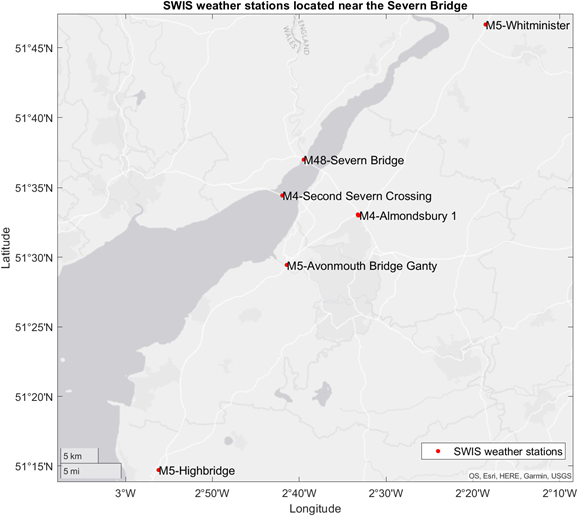

The following map shows the location of Severn site within UK:
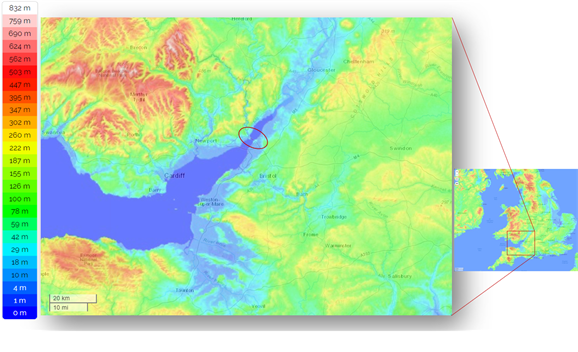

## Flowchart

In this study, we are trying to predict the wind gust speed and wind gust direction for the station that is located on the Severn Bridge, "M48 - Severn Station", 1 hour into the future, given the current and past weather-data from 5 stations (although the flowchart below shows only 2 stations).

We use a Recurrent Neural Network (RNN) because it can work on sequences of arbitrary length. (Sub-sequences of 1008 data-points (1 weeks) from the training-set is used during training, with each data-point or observation having 20 input-signals for the temperature, humidity, etc. for each of the 5 stations.) We then want to train the NN so it outputs the 2 signals for 1-hour ahead wind-speed and direction.

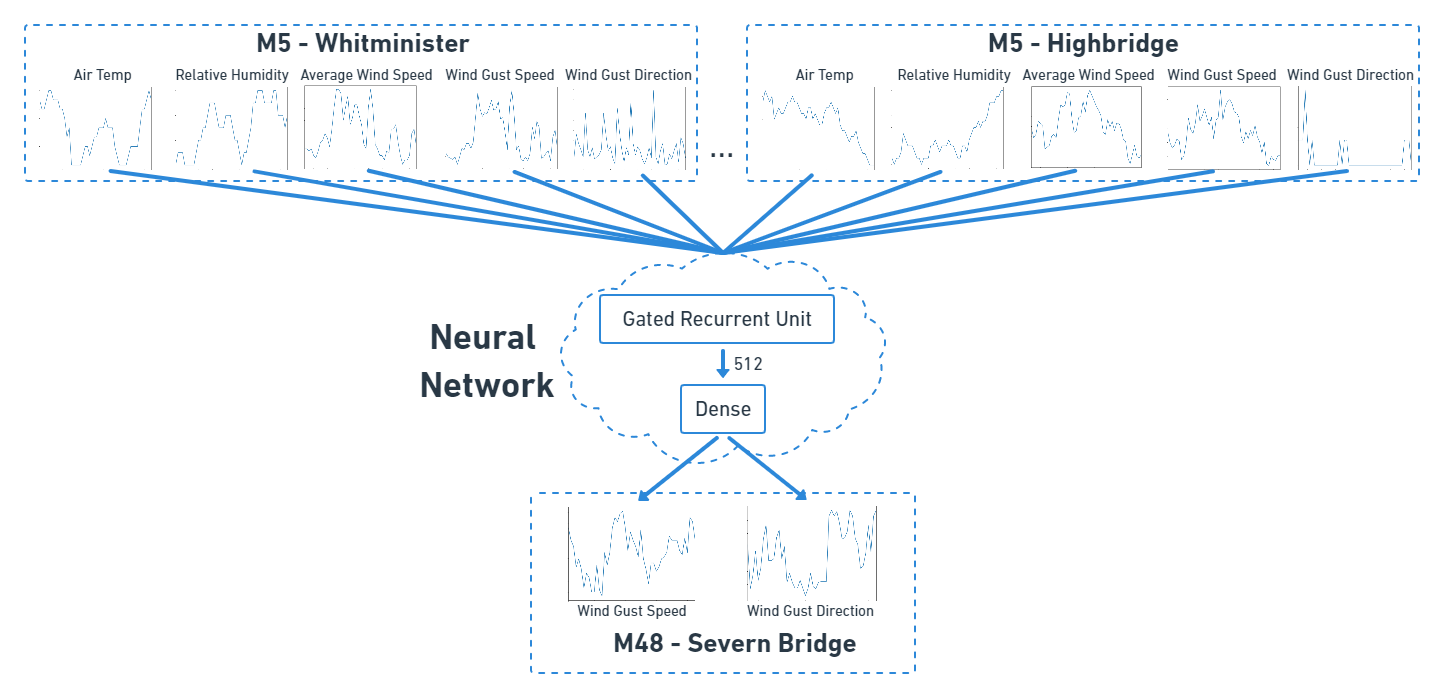

## Imports

In [2]:
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['figure.figsize'] = (10, 4)
mpl.rcParams['axes.grid'] = False

#We need to import several things from Keras.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

This was developed using Python 3.8 (Anaconda) and package versions:

In [4]:
tf.__version__

'2.3.0'

In [5]:
tf.keras.__version__

'2.4.0'

In [6]:
pd.__version__

'1.1.3'

## Load Data

In [85]:
wd =  pd.read_csv('Try4_Keras.csv')
wd.set_index('Date Time')
wd['Date Time'] = pd.to_datetime(wd['Date Time'])
wd.set_index(['Date Time'], inplace=True)
wd 

,Whitminister: Air Temp.1,Relative Humidity.1,Av. Wind Speed.1,Wind Gust Speed.1,Wind Gust Direction.1,M48Severn: Air Temp,Relative Humidity,Av. Wind Speed,Wind Gust Speed (km/h),Wind Gust Direction (deg),...,M4Almondsbury: Air Temp.4,Relative Humidity.4,Av. Wind Speed.4,Wind Gust Speed.4,Wind Gust Direction.4,M5Highbridge: Air Temp.5,Relative Humidity.5,Av. Wind Speed.5,Wind Gust Speed.5,Wind Gust Direction.5
Date Time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,9.6,78.0,24.12,37.44,330.0,9.2,83.0,19.80,27.36,196.0,...,8.9,85.0,0.36,8.64,213.0,9.7,86.0,9.72,20.52,215.0
2015-01-01 00:10:00,9.7,78.0,20.52,33.12,329.0,9.2,83.0,18.36,23.40,192.0,...,9.0,85.0,1.08,10.44,232.0,9.7,86.0,10.80,24.12,206.0
2015-01-01 00:20:00,9.6,79.0,21.24,30.96,333.0,9.0,83.0,18.00,21.96,196.0,...,9.1,85.0,3.24,18.36,237.0,9.6,87.0,12.96,26.28,213.0
2015-01-01 00:30:00,9.6,79.0,19.08,31.32,336.0,8.9,84.0,17.28,24.12,200.0,...,9.3,84.0,2.16,14.76,264.0,9.5,88.0,9.00,22.68,210.0
2015-01-01 00:40:00,9.5,80.0,13.32,22.68,343.0,9.1,83.0,20.52,26.28,205.0,...,9.5,83.0,2.88,18.72,305.0,9.4,88.0,7.20,16.20,205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:10:00,8.9,75.0,7.20,12.60,294.0,8.8,76.0,0.00,2.52,244.0,...,8.3,80.0,2.52,12.24,313.0,9.3,92.0,9.00,16.20,232.0
2018-12-31 23:20:00,8.8,77.0,5.76,8.64,294.0,8.8,77.0,0.00,0.36,244.0,...,8.4,80.0,3.24,12.24,328.0,9.2,92.0,7.20,15.48,234.0
2018-12-31 23:30:00,8.8,77.0,6.84,11.52,322.0,8.9,76.0,0.00,0.00,244.0,...,8.3,80.0,3.60,11.88,339.0,9.2,92.0,6.48,14.40,243.0


plot_cols = ['Whitminister: Air Temp.1','Relative Humidity.1','Wind Gust Speed.1','Wind Gust Direction.1',
             'M48Severn: Air Temp','Relative Humidity','Wind Gust Speed (km/h)','Wind Gust Direction (deg)',
            'M4SecondSevern: Air Temp.3','Relative Humidity.3','Wind Gust Speed.3','Wind Gust Direction.3',
            'M4Almondsbury: Air Temp.4','Relative Humidity.4','Wind Gust Speed.4','Wind Gust Direction.4',
            'M5Highbridge: Air Temp.5','Relative Humidity.5','Wind Gust Speed.5','Wind Gust Direction.5']
plot_features = wd[plot_cols]
_ = plot_features.plot(subplots=True)

plot_features = wd[plot_cols][:480]
_ = plot_features.plot(subplots=True)

Statistics of the dataset:

In [15]:
wd.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Whitminister: Air Temp.1,210384.0,11.222595,5.871238,-6.4,7.000000,11.200000,15.300000,33.80
Relative Humidity.1,210384.0,76.833320,13.378829,14.0,69.000000,80.000000,87.000000,97.00
Av. Wind Speed.1,210384.0,7.539466,5.322316,0.0,3.600000,6.120000,10.080000,56.52
Wind Gust Speed.1,210384.0,15.032119,8.570491,0.0,8.880714,13.320000,19.440000,74.88
Wind Gust Direction.1,210384.0,231.949771,96.379283,0.0,179.000000,257.000000,304.000000,357.00
M48Severn: Air Temp,210384.0,11.293147,5.189295,-5.4,7.400000,11.200000,15.174743,33.20
Relative Humidity,210384.0,79.080068,13.310305,19.0,71.000000,81.000000,89.000000,100.00
Av. Wind Speed,210384.0,7.034214,8.682640,0.0,0.000000,3.600000,11.165590,61.56
Wind Gust Speed (km/h),210384.0,14.762412,12.558854,0.0,3.960000,12.600000,22.680000,86.04
Wind Gust Direction (deg),210384.0,195.122653,101.587463,0.0,119.000000,222.000000,264.000000,357.00


### Missing Data

The M5-Almondsbury have poor data for the gust speed. This may confuse the neural network. For simplicity, we will simply remove this signal from the data.

In [16]:
#wd['M4SecondSevern: Air Temp.3'].plot();

In [17]:
#wd['Relative Humidity.3'].plot();

In [18]:
#wd['Av. Wind Speed.3'].plot();

In [19]:
#wd['Wind Gust Speed.3'].plot();

In [20]:
#wd['Wind Gust Direction.3'].plot();

Before removing the one signal, there are 20 input-signals in the data-set.

In [21]:
wd.drop(('M4SecondSevern: Air Temp.3'),axis=1, inplace=True)
wd.drop(('Relative Humidity.3'),axis=1, inplace=True)
wd.drop(('Av. Wind Speed.3'),axis=1, inplace=True)
wd.drop(('Wind Gust Speed.3'),axis=1, inplace=True)
wd.drop(('Wind Gust Direction.3'),axis=1, inplace=True)

In [22]:
wd.values.shape

(210384, 20)

Now that we removed the signal we have 19 columns.

We can verify that this data-column has indeed been removed.

In [23]:
wd.head(1)

,Whitminister: Air Temp.1,Relative Humidity.1,Av. Wind Speed.1,Wind Gust Speed.1,Wind Gust Direction.1,M48Severn: Air Temp,Relative Humidity,Av. Wind Speed,Wind Gust Speed (km/h),Wind Gust Direction (deg),M4Almondsbury: Air Temp.4,Relative Humidity.4,Av. Wind Speed.4,Wind Gust Speed.4,Wind Gust Direction.4,M5Highbridge: Air Temp.5,Relative Humidity.5,Av. Wind Speed.5,Wind Gust Speed.5,Wind Gust Direction.5
Date Time,,,,,,,,,,,,,,,,,,,,
2015-01-01,9.6,78.0,24.12,37.44,330.0,9.2,83.0,19.8,27.36,196.0,8.9,85.0,0.36,8.64,213.0,9.7,86.0,9.72,20.52,215.0


### Data Errors

In [24]:
#df['station']['Temp']['2016-05':'2016-07'].plot();
#wd['Av. Wind Speed.5'][200:200+50].plot();

### Add Data
We can add some input-signals to the data that may help our model in making predictions.

For example, given just a temperature of 10 degrees Celcius the model wouldn't know whether that temperature was measured during the day or the night, or during summer or winter. The model would have to infer this from the surrounding data-points which might not be very accurate for determining whether it's an abnormally warm winter, or an abnormally cold summer, or whether it's day or night. So having this information could make a big difference in how accurately the model can predict the next output.

Although the data-set does contain the date and time information for each observation, it is only used in the index so as to order the data. We will therefore add separate input-signals to the data-set for the day-of-year (between 1 and 366) and the hour-of-day (between 0 and 23).
However 90% it is wrong the way I have added the time. Let me check it again Nick.

In [25]:
wd['Various', 'Day'] = wd.index.dayofyear
wd['Various', 'Hour'] = wd.index.hour

### Target Data for Prediction

We will try and predict the future weather-data for the M48 station.
We will try and predict these signals:

In [26]:
target_variables = ['Wind Gust Speed (km/h)','Wind Gust Direction (deg)']

The following is the number of time-steps that we will shift the target-data. 

If we want to predict the wind 1 hour into the future, we shift the data 6 time-step. If we want to predict the weather 2 hours into the future, we shift the data 2 * 6 time-steps.

In [27]:
shift_hours = 1 # Number of hours.
shift_steps = shift_hours * 6  

Creating a new data-frame with the time-shifted data.

In [28]:
wd_target = wd[target_variables].shift(-shift_steps)

The shifted data-frame is confusing because Pandas keeps the original time-stamps even though we have shifted the data. That is why we check the time-shift is correct by comparing the original and time-shifted data-frames.

This is the first `shift_steps + 5` rows of the original data-frame:

In [86]:
#wd[target_variables].head(shift_steps + 5)

The following is the first 5 rows of the time-shifted data-frame. This should be identical to the last 5 rows shown above from the original data, except for the time-stamp.

In [87]:
#wd_target.head(5)

The time-shifted data-frame has the same length as the original data-frame, but the last observations are `NaN` (not a number) because the data has been shifted backwards so we are trying to shift data that does not exist in the original data-frame.

In [88]:
#wd_target.tail()

### NumPy Arrays

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network. (We also remove the last part of the numpy arrays, because the target-data has `NaN` for the shifted period, and we only want to have valid data and we need the same array-shapes for the input- and output-data.)

These are the input-signals:

In [32]:
x_data = wd.values[0:-shift_steps]

In [33]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (210378, 22)


These are the output-signals (or target-signals):

In [34]:
y_data = wd_target.values[:-shift_steps]

In [35]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (210378, 2)


This is the number of observations (aka. data-points or samples) in the data-set:

In [36]:
num_data = len(x_data)
num_data

210378

This is the fraction of the data-set that will be used for the training-set:

In [37]:
train_split = 0.9

This is the number of observations in the training-set:

In [38]:
num_train = int(train_split * num_data)
num_train

189340

This is the number of observations in the test-set:

In [39]:
num_test = num_data - num_train
num_test

21038

These are the input-signals for the training- and test-sets:

In [40]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

210378

These are the output-signals for the training- and test-sets:

In [41]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

210378

This is the number of input-signals:

In [42]:
num_x_signals = x_data.shape[1]
num_x_signals

22

This is the number of output-signals:

In [43]:
num_y_signals = y_data.shape[1]
num_y_signals

2

### Scaled Data

The data-set contains a wide range of values:

In [44]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -6.4
Max: 366.0


The neural network works best on values roughly between -1 and 1, so we need to scale the data before it is being input to the neural network. We can use `scikit-learn` for this.

We first create a scaler-object for the input-signals.

In [45]:
x_scaler = MinMaxScaler()

We then detect the range of values from the training-data and scale the training-data.

In [46]:
x_train_scaled = x_scaler.fit_transform(x_train)

Apart from a small rounding-error, the data has been scaled to be between 0 and 1.

In [47]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


We use the same scaler-object for the input-signals in the test-set.

In [48]:
x_test_scaled = x_scaler.transform(x_test)

The target-data comes from the same data-set as the input-signals, because it is the weather-data for one of the stations that is merely time-shifted. But the target-data could be from a different source with different value-ranges, so we create a separate scaler-object for the target-data.

In [49]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Data Generator

The data-set has now been prepared as 2-dimensional numpy arrays. The training-data has almost 8millions observations, consisting of 21 input-signals and 2 output-signals.

These are the array-shapes of the input and output data:

In [50]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(189340, 22)
(189340, 2)


Instead of training the Recurrent Neural Network on the complete sequences of almost 8m observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [51]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

We will use a large batch-size so as to keep the GPU near 100% work-load.

In [52]:
batch_size = 256

We will use a sequence-length of 1008, which means that each random sequence contains observations for 1 hours. One time-step corresponds to 10min, so 6 x 24 x 7 time-steps corresponds to a week.

In [53]:
sequence_length = 6 * 24 * 7
sequence_length

1008

We then create the batch-generator.

In [54]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

We can then test the batch-generator to see if it works.

In [55]:
x_batch, y_batch = next(generator)

This gives us a random batch of 256 sequences, each sequence having 1008 observations, and each observation having 21 input-signals and 2 output-signals.

In [56]:
print(x_batch.shape)
print(y_batch.shape)

(256, 1008, 22)
(256, 1008, 2)


We can plot one of the 21 input-signals as an example.

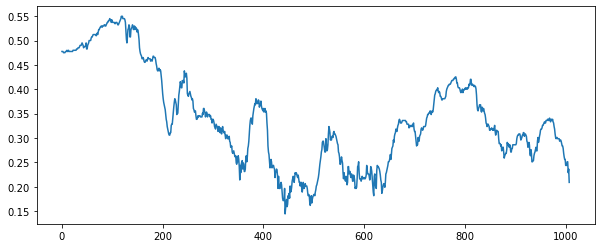

In [57]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 21 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

We can also plot one of the output-signals that we want the model to learn how to predict given all those 21 input signals.

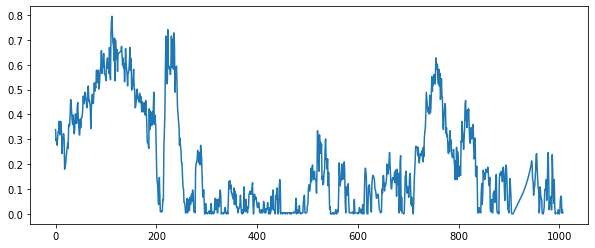

In [58]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation Set

The neural network trains quickly so we can easily run many training epochs (not in my pc). But then there is a risk of overfitting the model to the training-set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each epoch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [59]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## Create the Recurrent Neural Network

We will use the Keras API for this because of its simplicity.

In [60]:
model = Sequential()

We can now add a Gated Recurrent Unit (GRU) to the network. This will have 512 outputs for each time-step in the sequence.

Note that because this is the first layer in the model, Keras needs to know the shape of its input, which is a batch of sequences of arbitrary length (indicated by `None`), where each observation has a number of input-signals (`num_x_signals`).

In [61]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))


The GRU outputs a batch of sequences of 512 values. We want to predict 2 output-signals, so we add a fully-connected (or dense) layer which maps 512 values down to only 2 values.

The output-signals in the data-set have been limited to be between 0 and 1 using a scaler-object. So we also limit the output of the neural network using the Sigmoid activation function, which squashes the output to be between 0 and 1.

In [62]:
model.add(Dense(num_y_signals, activation='sigmoid'))

A problem with using the Sigmoid activation function, is that we can now only output values in the same range as the training-data.

For example, if the training-data only has temperatures between -20 and +30 degrees, then the scaler-object will map -20 to 0 and +30 to 1. So if we limit the output of the neural network to be between 0 and 1 using the Sigmoid function, this can only be mapped back to temperature values between -20 and +30.

We can use a linear activation function on the output instead. This allows for the output to take on arbitrary values. It might work with the standard initialization for a simple network architecture, but for more complicated network architectures e.g. with more layers, it might be necessary to initialize the weights with smaller values to avoid `NaN` values during training.

In [63]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

### Loss Function

We will use Mean Squared Error (MSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.

However, at the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 50 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps.
bgazei αποτελεσμα για το ποσο απεχουν τα δεδομενα που προβλεψε απο τα πραγματικα μετα καθε bach

In [64]:
warmup_steps = 50

### Compile Model

This is the optimizer and the beginning learning-rate that we will use.

In [66]:
optimizer = RMSprop(lr=1e-3)

We then compile the Keras model so it is ready for training.

In [67]:
model.compile(loss=tf.losses.MeanAbsoluteError(), optimizer=optimizer, metrics=['mse'])

This is a very small model with only two layers. The output shape of `(None, None, 2)` means that the model will output a batch with an arbitrary number of sequences, each of which has an arbitrary number of observations, and each observation has 2 signals. This corresponds to the 2 target signals we want to predict.

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         823296    
_________________________________________________________________
dense (Dense)                (None, None, 2)           1026      
Total params: 824,322
Trainable params: 824,322
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [69]:
path_checkpoint = 'Checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [70]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

This is the callback for writing the TensorBoard log during training.

In [71]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by `patience=0`). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [72]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [73]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Train the Recurrent Neural Network

We can now train the neural network.

Note that a single "epoch" does not correspond to a single processing of the training-set, because of how the batch-generator randomly selects sub-sequences from the training-set. Instead we have selected `steps_per_epoch` so that one "epoch" is processed in a some minutes.

In [74]:
%%time
history = model.fit(x=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
  1/100 [..............................] - ETA: 0s - loss: 0.2659 - mse: 0.0909WARNING:tensorflow:From F:\Users\Freyja\anaconda3\envs\ml2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - ETA: 0s - loss: 0.1510 - mse: 0.0466 
Epoch 00001: val_loss improved from inf to 0.05512, saving model to Checkpoint.keras
100/100 [==============================] - 2112s 21s/step - loss: 0.1510 - mse: 0.0466 - val_loss: 0.0551 - val_mse: 0.0059
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.1290 - mse: 0.0406 
Epoch 00002: val_loss did not improve from 0.05512

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 3085s 31s/step - loss: 0.1290 - mse: 0.0406 - val_loss: 0.09

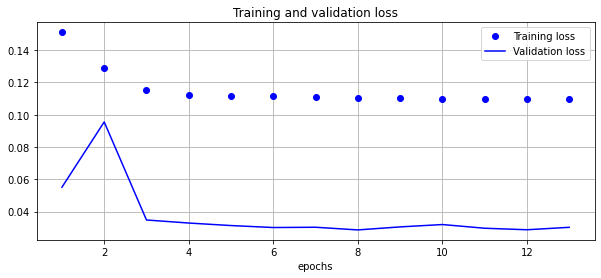

In [75]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
mpl.rcParams['figure.figsize'] = (3, 2.5)
plt.grid(True)
plt.rcParams.update({#"font.weight": "bold",
    #"xtick.major.size": 5,#"xtick.major.pad": 7,#"xtick.labelsize": 15,
    "grid.color": "0.5",
    "grid.linestyle": ":",
    "grid.linewidth": 0.2,
    #"lines.linewidth": 2,
    #"lines.color": "g"
})
plt.xlabel('epochs')
plt.show()

### Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [76]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [77]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 0s/step - loss: 0.0287 - mse: 0.0023


In [78]:
print("loss (test-set):", result)

loss (test-set): [0.028704751282930374, 0.002281492343172431]


In [79]:
# If we have several metrics we can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [80]:
model.save(filepath='Wind_Model_MAE_1h_drop_20epochs.h5')

## Generate Predictions

This helper-function plots the predicted and true output-signals.

In [81]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_variables)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(10,4))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='observed',linewidth=1.0)
        plt.plot(signal_pred, label='predicted',linewidth=1.0)
        plt.plot(signal_true - signal_pred, label='residual',linewidth=1.0)
        plt.grid(True)
        plt.rcParams.update({
           #"font.weight": "bold",
           #"xtick.major.size": 5,
           #"xtick.major.pad": 7,
           #"xtick.labelsize": 15,
           "grid.color": "0.5",
           "grid.linestyle": ":",
           "grid.linewidth": 0.1,
           #"lines.linewidth": 2,
           #"lines.color": "g",
        })
        plt.xlabel('time_step (10min)')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_variables[signal])
        plt.legend()
        plt.show()

These plots only show the output-signals and not the 20 input-signals used to predict the output-signals. The time-shift between the input-signals and the output-signals is held fixed in these plots. The model **always** predicts the output-signals e.g. 1 hours into the future (as defined in the `shift_steps` variable above). So the plot's x-axis merely shows how many time-steps of the input-signals have been seen by the predictive model so far.

The prediction is not very accurate for the first 30-50 time-steps because the model has seen very little input-data at this point.
The model generates a single time-step of output data for each time-step of the input-data, so when the model has only run for a few time-steps, it knows very little of the history of the input-signals and cannot make an accurate prediction. The model needs to "warm up" by processing perhaps 30-50 time-steps before its predicted output-signals can be used.

That is why we ignore this "warmup-period" of 50 time-steps when calculating the mean-squared-error in the loss-function. The "warmup-period" is shown as a grey box in these plots.

Let us start with an example from the training-data. This is data that the model has seen during training so it should perform reasonably well on this data.

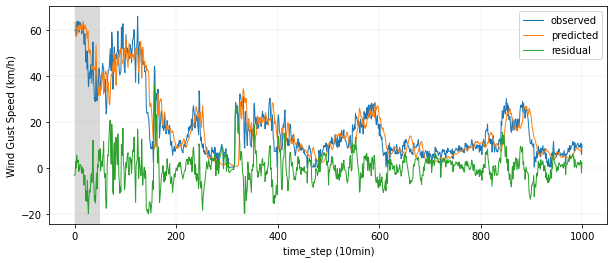

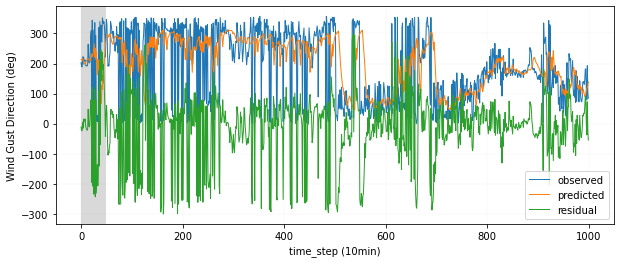

In [82]:
plot_comparison(start_idx=2000, length=1000, train=True)

The model was able to predict the overall oscillations of the wind gust speed quite well but the peaks were sometimes inaccurate. For the wind gust direction, the overall predominant values have been predicted; however the 0 to 360 cycles of the direction seems to confuse the NN.

### Another Example

The following is another example from the training-set.

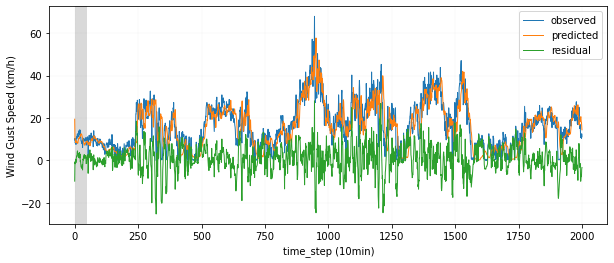

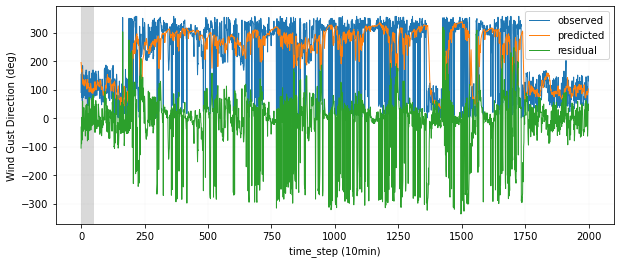

In [83]:
plot_comparison(start_idx=3000, length=2000, train=True)

### Example from Test-Set

The model has not seen this data during training.

The wind gust speed is predicted reasonably well, although the peaks are sometimes inaccurate.

The wind gust direction has not been predicted well. The wind direction is difficult to predict from the given input data, so the model has merely learnt to output sinusoidal oscillations in the daily frequency.

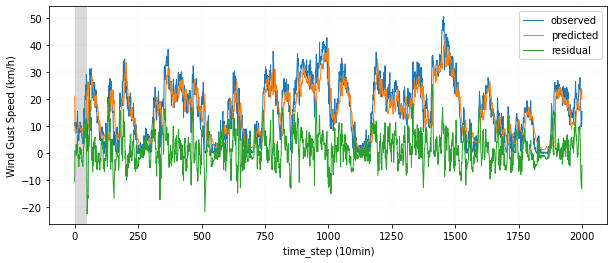

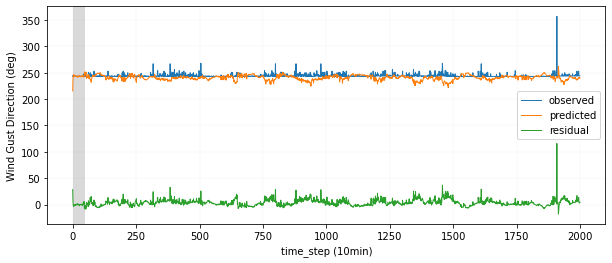

In [84]:
plot_comparison(start_idx=200, length=2000, train=False)

## Conclusion

This study showed that GRU could predict the wind gust speed of M48 station given weather data from 5 stations enough satisfactory. However they had not an accurate performance in predicting wind gust direction, which was expected, as the direction has a cycle of 0-360 degrees which confuses the NN. Another approach could be to change direction onto vectors of sin and cos.